In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,GridSearchCV
from skopt import BayesSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
import statsmodels.api as sm
import itertools

from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import BDay

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

In [35]:
def data_loading(ticker_symbol, start_date, end_date):
    # Fetch the ETF data from Yahoo Finance for the period from 2010-01-01 to 2024-01-01
    etf_data = yf.Ticker(ticker_symbol)
    etf_history = etf_data.history(start=start_date, end=end_date)
    etf_history.index = etf_history.index.tz_localize(None)
    return etf_history, etf_data

In [36]:
#Function to derive the predictor columns
def etf_predictors(etf_history,  start_date, end_date, etf_data, benchmark_ticker = '^GSPC' ):
    
    # Calculate Daily Returns
    etf_history['Daily Return'] = etf_history['Close'].pct_change()

    # Calculate 21-Day Volatility (standard deviation of daily returns, annualized)
    etf_history['Volatility'] = etf_history['Daily Return'].rolling(window=21).std() * np.sqrt(252)
    #etf_history['Volatility_ta'] = ta.volatility(etf_history['Close'], window=21, annualize=True)
   
    # Get the ETF info
    etf_info = etf_data.info

    # Retrieve the net asset value price (NAV) and total net assets
    nav_price = etf_info['navPrice']
    total_assets = etf_info['totalAssets']

    # Calculate the number of shares outstanding
    shares_outstanding = total_assets / nav_price

    # Calculate Market Capitalization for each day
    # Market Capitalization = Closing Price * Total Number of Shares Outstanding
    etf_history['Market Cap'] = etf_history['Close'] * shares_outstanding

    total_assets = etf_info['totalAssets']
    total_liabilities = etf_info.get('totalLiabilities', 0)  # Handle the case where total liabilities might not be present
    
    # Calculate Book Value per Share
    book_value_per_share = (total_assets - total_liabilities) / shares_outstanding
    
    # Calculate Price to Book (P/B) Ratio
    etf_history['P/B Ratio'] = etf_history['Close'] / book_value_per_share
    
    # Calculate 1-Month Momentum (21 trading days)
    
    etf_history['Momentum'] = ta.mom(etf_history['Close'], length=21)
    
    benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date)
    benchmark_data['Daily Return'] = benchmark_data['Close'].pct_change()
    #benchmark_data_history = benchmark_data.dropna()
    benchmark_data.head(10)
    
    # Ensure the indices are time zone-naive
    benchmark_data.index = benchmark_data.index.tz_localize(None)
    combined_data = etf_history[['Close']].join(benchmark_data[['Close']], lsuffix='_ETF', rsuffix='_Benchmark')
    combined_data = combined_data.dropna()
    
    # Calculate rolling beta with a 30-day window
    rolling_beta_21 = rolling_beta(combined_data, window=21)

    # Add the rolling beta to the dataframe
    combined_data.loc[:, 'Rolling Beta 21-day'] = rolling_beta_21
    etf_history['Rolling Beta']=combined_data['Rolling Beta 21-day']
    
    # Calculate daily profitability
    daily_profitabilities = []
    previous_nav = None
    for index, row in etf_history.iterrows():
        current_nav = row['Close']  # Current day's NAV
        #print(current_nav)
        if previous_nav is not None:
            daily_profitability = (current_nav - previous_nav) / previous_nav * 100
            daily_profitabilities.append(daily_profitability)
        else:
            daily_profitabilities.append(None)
        previous_nav = current_nav  # Update previous_nav for the next iteration

    # Add daily profitabilities to ETF dataset
    etf_history['Daily Profitability (%)'] = daily_profitabilities
    
    # Calculate the dividend yield for each day
    dividend_yields = []

    for index, row in etf_history.iterrows():
        # Get the dividend payment for the day
        dividend_payment = row['Dividends']

        # Get the current market price of the ETF for the day
        current_price = row['Close']

        # Calculate the dividend yield for the day
        dividend_yield = (dividend_payment / current_price) * 100

        # Append the dividend yield to the list
        dividend_yields.append(dividend_yield)
      
    etf_history['Div yield'] = dividend_yields

    #Volatility
    etf_history['ATR'] = ta.atr(etf_history['High'], etf_history['Low'], etf_history['Close'], length=21)    
    
    # Compute the Relative Volatility Index (RVI)
    rvi = ta.rvi(etf_history['Close'],length=21)
    etf_history['RVI'] = rvi
    
    #Momentum
    rsi_window = 14  # Window size for RSI calculation
    roc_window = 12  # Window size for ROC calculation
    #rsi_window = 21  
    #roc_window = 21  

    

    etf_history['RSI'] = ta.rsi(etf_history['Close'],length=rsi_window)
    # Calculate Rate of Change (ROC)
    etf_history['ROC'] = ta.roc(etf_history['Close'], length=roc_window)
        
    etf_history['log_returns'] = np.log(etf_history['Close'] / etf_history['Close'].shift(1))

    return etf_history

# Function to calculate rolling beta
def rolling_beta(df, window):
    rolling_cov = df['Close_Benchmark'].rolling(window=window).cov(df['Close_ETF'])
    rolling_var = df['Close_Benchmark'].rolling(window=window).var()
    rolling_beta = rolling_cov / rolling_var
    return rolling_beta



In [37]:

def pre_processing(etf_history, train_start_date, train_end_date, test_start_date, test_end_date, prediction_dates, feature_columns=None, scaling_strategy='StandardScaler', final_end_date='2024-12-01'):
    # Handle missing values and inf replacements
    etf_history.fillna(etf_history.median(), inplace=True)
    etf_history = etf_history.replace(-np.inf, 0)

    # Default feature columns if none are provided
    if feature_columns is None:
        feature_columns = ['Volatility', 'Volume', 'Daily Return', 'Market Cap', 'P/B Ratio', 'Momentum', 
                           'Rolling Beta', 'Daily Profitability (%)', 'ATR', 'RVI', 'RSI', 'ROC']

    # Selecting the features (X) and the target (y)
    X = etf_history.loc[:, feature_columns]
    y = etf_history['log_returns']

    # Split train and test data
    train_data = X.loc[train_start_date:train_end_date]
    test_data = X.loc[test_start_date:test_end_date]
    y_train = y.loc[train_start_date:train_end_date]
    y_test = y.loc[test_start_date:test_end_date]

    # Scaling strategy based on input parameter
    if scaling_strategy == 'StandardScaler':
        scaler = StandardScaler()
    elif scaling_strategy == 'Normalizer':
        scaler = Normalizer()
    else:
        raise ValueError(f"Unsupported scaling strategy: {scaling_strategy}")
    
    # Scaling the train and test data
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Create a dictionary to store forecast data for each prediction period
    forecast_data = {}
    for i, start_date in enumerate(prediction_dates):
        # Determine the end date for each forecast period
        if i < len(prediction_dates) - 1:
            end_date = (pd.to_datetime(start_date) + MonthEnd(0)).strftime('%Y-%m-%d')
        else:
            end_date = final_end_date  # The final end date provided or default

        # Store the forecast data for each period
        forecast_data[f'forecast_data_{i+1}m'] = X.loc[start_date:end_date]

    # Scale the forecast data dynamically
    forecast_data_scaled = {}
    for period_key, period_data in forecast_data.items():
        if not period_data.empty:
            forecast_data_scaled[period_key] = sm.add_constant(scaler.transform(period_data))

    # Add constant to scaled train and test data
    train_data_scaled = sm.add_constant(train_data_scaled)
    test_data_scaled = sm.add_constant(test_data_scaled)

    # Dynamically return the scaled forecast data along with train and test data
    return {
        'train_data_scaled': train_data_scaled,
        'test_data_scaled': test_data_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'X': X,
        'etf_history': etf_history,
        'forecast_data_scaled': forecast_data_scaled,
        'forecast_data': forecast_data
    }


In [38]:
def model_training(train_data_scaled, y_train):
    model = sm.OLS(endog=y_train, exog=sm.add_constant(train_data_scaled))
    
     # Define the hyperparameters
    cov_types = ['HC0', 'HC1', 'HC2', 'HC3']
    use_ts = [True, False]
    methods = ['pinv', 'qr']
    #missing = ['none', 'drop', 'raise']
    #hasconsts = [None, 'add', 'raise']
    tol_values = [1e-8, 1e-6, 1e-4]
    maxiter_values = [500, 1000, 5000]

    best_score = float('-inf')
    best_model = None

    # Loop through all combinations of hyperparameters
    for cov_type, use_t, method, tol, maxiter in itertools.product(cov_types, use_ts, methods,  tol_values, maxiter_values):
        try:
            # Define and fit the model
            model = sm.OLS(endog=y_train, exog=train_data_scaled)
            fitted_model = model.fit(cov_type=cov_type, use_t=use_t, method=method, tol=tol, maxiter=maxiter)

            # Evaluate on test data
            score = fitted_model.rsquared_adj  # Or any other metric you prefer

            # Update best model if necessary
            if score > best_score:
                best_score = score
                best_model = fitted_model
                best_params = {
                    'cov_type': cov_type,
                    'use_t': use_t,
                    'method': method,
                    #'missing': miss,
                    #'hasconst': hasconst,
                    'tol': tol,
                    'maxiter': maxiter
                }
        except:
            # Handle any errors that arise from invalid hyperparameter combinations
            continue
            
    # Display the best model parameters
    print("Best Model Parameters:")
    print(best_params)
    return best_model

In [39]:
#!pip install scikit-optimize


In [40]:
def eval_model(best_model,test_data_scaled,y_test,y_train):
    
    test_predictions = best_model.predict((test_data_scaled))
    mae = mean_absolute_error(y_test, test_predictions)
    # Mean Absolute Scaled Error (MASE) - Example calculation assuming seasonal period m=1
    seasonal_naive = np.roll(y_test, 1)  # Shift y_test by 1 for seasonal naive forecast
    #seasonal_mae = np.mean(np.abs(y_test - seasonal_naive))
    seasonal_mae = np.mean(np.abs(y_test[1:] - seasonal_naive[1:]))
    mase = mae / seasonal_mae

    # Mean Absolute Percentage Error (MAPE)
    #mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100

    #n = y_test.shape[0]
    #d = np.abs(  np.diff( y_test) ).sum()/(n-1)
    
    #errors = np.abs(y_test - test_predictions )
    #mase_value = errors.mean()/d

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Absolute Scaled Error (MASE):", mase)
    #print("Mean Absolute Scaled Error-2 (MASE-2):", mase_value)
    #print("Mean Absolute Percentage Error (MAPE):", mape)
    
    return mae, mase

In [41]:
# Ensured consistent feature handling and forecasting in predictions
def predictions(model, forecast_data_scaled, forecast_data):
    predictions_forecast = model.predict(forecast_data_scaled)
    forecast_predictions_df = pd.DataFrame(predictions_forecast, columns=["log_returns"], index=forecast_data.index)
    forecast_data_with_predictions = pd.concat([forecast_data, forecast_predictions_df], axis=1)
    return forecast_predictions_df, forecast_data_with_predictions

In [42]:
"""
# Ensured consistent feature handling and forecasting in predictions
def predictions(model, forecast_data_scaled, forecast_data):
    predictions_forecast = model.predict(forecast_data_scaled)
    forecast_predictions_df = pd.DataFrame(predictions_forecast, columns=["log_returns"], index=forecast_data.index)
    forecast_data_with_predictions = pd.concat([forecast_data, forecast_predictions_df], axis=1)
    return forecast_predictions_df, forecast_data_with_predictions
    """

'\n# Ensured consistent feature handling and forecasting in predictions\ndef predictions(model, forecast_data_scaled, forecast_data):\n    predictions_forecast = model.predict(forecast_data_scaled)\n    forecast_predictions_df = pd.DataFrame(predictions_forecast, columns=["log_returns"], index=forecast_data.index)\n    forecast_data_with_predictions = pd.concat([forecast_data, forecast_predictions_df], axis=1)\n    return forecast_predictions_df, forecast_data_with_predictions\n    '

In [43]:
tickers = ['SPY', 'QQQ', 'VTI', 'IWM', 'EFA', 'EEM', 'GLD', 'SLV', 'USO', 'XLF']
#tickers = ['SPY', 'QQQ', 'VTI']
#tickers = ['SPY']
                                                           
start_date, end_date = '2000-01-01', '2024-12-01'
train_start_date, train_end_date, test_start_date, test_end_date, prediction_start_date = start_date,'2014-01-01', '2014-01-01', '2024-01-01', '2024-01-01'
prediction_dates=['2024-01-01','2024-02-01','2024-03-01', '2024-04-01','2024-05-01','2024-06-01','2024-07-01','2024-08-01','2024-09-01','2024-10-01','2024-11-01']

In [44]:
dict_data = {}
etf_dict = {}
data_with_predictors = []
for i in tickers:
    etf_history,etf_data = data_loading(i, start_date, end_date)
    
    print(etf_data.info.get('longName'), ":",i)
    
    #test_stationarity(etf_history)
    print(" ETF:",i)
    #print(etf_history.head(10))
    #print("################")
    #hist_data.append(etf_history)
    
    etf_history = etf_predictors(etf_history,  start_date, end_date, etf_data,benchmark_ticker = '^GSPC' )
    #print(etf_history.head(10))
    #rolling_beta(etf_history, window)
    
    # Call the function
    preprocessed_data = pre_processing(etf_history, train_start_date, train_end_date, test_start_date, test_end_date, prediction_dates)

    # Extract individual components from the returned dictionary
    train_data_scaled = preprocessed_data['train_data_scaled']
    test_data_scaled = preprocessed_data['test_data_scaled']
    y_train = preprocessed_data['y_train']
    y_test = preprocessed_data['y_test']
    scaler = preprocessed_data['scaler']
    X = preprocessed_data['X']
    etf_history = preprocessed_data['etf_history']

    # Optionally, access forecast data for each period
    forecast_data_scaled_1m = preprocessed_data['forecast_data_scaled'].get('forecast_data_1m')
    forecast_data_scaled_2m = preprocessed_data['forecast_data_scaled'].get('forecast_data_2m')
    forecast_data_scaled_3m = preprocessed_data['forecast_data_scaled'].get('forecast_data_3m')
    forecast_data_scaled_4m = preprocessed_data['forecast_data_scaled'].get('forecast_data_4m')
    forecast_data_scaled_5m = preprocessed_data['forecast_data_scaled'].get('forecast_data_5m')
    forecast_data_scaled_6m = preprocessed_data['forecast_data_scaled'].get('forecast_data_6m')
    forecast_data_scaled_7m = preprocessed_data['forecast_data_scaled'].get('forecast_data_7m')
    
    forecast_data_scaled_8m = preprocessed_data['forecast_data_scaled'].get('forecast_data_8m')
    forecast_data_scaled_9m = preprocessed_data['forecast_data_scaled'].get('forecast_data_9m')
    forecast_data_scaled_10m = preprocessed_data['forecast_data_scaled'].get('forecast_data_10m')
    forecast_data_scaled_11m = preprocessed_data['forecast_data_scaled'].get('forecast_data_11m')
    
    
    forecast_data_1m = preprocessed_data['forecast_data'].get('forecast_data_1m')
    forecast_data_2m = preprocessed_data['forecast_data'].get('forecast_data_2m')
    forecast_data_3m = preprocessed_data['forecast_data'].get('forecast_data_3m')
    forecast_data_4m = preprocessed_data['forecast_data'].get('forecast_data_4m')
    forecast_data_5m = preprocessed_data['forecast_data'].get('forecast_data_5m')
    forecast_data_6m = preprocessed_data['forecast_data'].get('forecast_data_6m')
    forecast_data_7m = preprocessed_data['forecast_data'].get('forecast_data_7m')
    
    forecast_data_8m = preprocessed_data['forecast_data'].get('forecast_data_8m')
    forecast_data_9m = preprocessed_data['forecast_data'].get('forecast_data_9m')
    forecast_data_10m = preprocessed_data['forecast_data'].get('forecast_data_10m')
    forecast_data_11m = preprocessed_data['forecast_data'].get('forecast_data_11m')
    

    #data_with_predictors.append(etf_history)
    #print(forecast_data)
    
    best_model = model_training(train_data_scaled, y_train)
    #print(model.summary())
    
    mae, mase = eval_model(best_model, test_data_scaled, y_test, y_train)
    print(len(forecast_data_scaled_1m))
    print(len(forecast_data_scaled_2m))
    print(len(forecast_data_scaled_3m))
    print(len(forecast_data_scaled_4m))
    print(len(forecast_data_scaled_5m))
    print(len(forecast_data_scaled_6m))
    print(len(forecast_data_scaled_7m))
    
    print(len(forecast_data_scaled_8m))
    print(len(forecast_data_scaled_9m))
    print(len(forecast_data_scaled_10m))
    print(len(forecast_data_scaled_11m))
    
    
    forecast_predictions_df_1m, forecast_data_with_predictions_1m = predictions(best_model, forecast_data_scaled_1m, forecast_data_1m)
    forecast_predictions_df_2m, forecast_data_with_predictions_2m = predictions(best_model, forecast_data_scaled_2m, forecast_data_2m)
    forecast_predictions_df_3m, forecast_data_with_predictions_3m = predictions(best_model, forecast_data_scaled_3m, forecast_data_3m)
    forecast_predictions_df_4m, forecast_data_with_predictions_4m = predictions(best_model, forecast_data_scaled_4m, forecast_data_4m)
    forecast_predictions_df_5m, forecast_data_with_predictions_5m = predictions(best_model, forecast_data_scaled_5m, forecast_data_5m)
    forecast_predictions_df_6m, forecast_data_with_predictions_6m = predictions(best_model, forecast_data_scaled_6m, forecast_data_6m)
    forecast_predictions_df_7m, forecast_data_with_predictions_7m = predictions(best_model, forecast_data_scaled_7m, forecast_data_7m)
    
    forecast_predictions_df_8m, forecast_data_with_predictions_8m = predictions(best_model, forecast_data_scaled_8m, forecast_data_8m)
    forecast_predictions_df_9m, forecast_data_with_predictions_9m = predictions(best_model, forecast_data_scaled_9m, forecast_data_9m)
    forecast_predictions_df_10m, forecast_data_with_predictions_10m = predictions(best_model, forecast_data_scaled_10m, forecast_data_10m)
    forecast_predictions_df_11m, forecast_data_with_predictions_11m = predictions(best_model, forecast_data_scaled_11m, forecast_data_11m)
    
    
    # Add data to dictionary
    # Store the relevant data in a dictionary

    #print(forecast_predictions_df_6m)
    #print(forecast_predictions_df_7m)
    
    dict_data = {
        "etf_history": etf_history,
        "forecast_data_1m": forecast_data_1m,
        "forecast_data_2m": forecast_data_2m,
        "forecast_data_3m": forecast_data_3m,
        "forecast_data_4m": forecast_data_4m,
        "forecast_data_5m": forecast_data_5m,
        "forecast_data_6m": forecast_data_6m,
        "forecast_data_7m": forecast_data_7m,
        
        "forecast_data_8m": forecast_data_8m,
        "forecast_data_9m": forecast_data_9m,
        "forecast_data_10m": forecast_data_10m,
        "forecast_data_11m": forecast_data_11m,
        
        "X": X,
        "y_train_values": y_train , # Assuming this is relevant to the ETF data
        "model results": {"mae": mae,
                          "mase": mase,
                          #"mape": mape
                         },
                         
        "forecast_predictions_df_1m" : forecast_predictions_df_1m['log_returns'].values,
        "forecast_predictions_df_2m" : forecast_predictions_df_2m['log_returns'].values,
        "forecast_predictions_df_3m" : forecast_predictions_df_3m['log_returns'].values,
        "forecast_predictions_df_4m" : forecast_predictions_df_4m['log_returns'].values,
        "forecast_predictions_df_5m" : forecast_predictions_df_5m['log_returns'].values,
        "forecast_predictions_df_6m" : forecast_predictions_df_6m['log_returns'].values,
        "forecast_predictions_df_7m" : forecast_predictions_df_7m['log_returns'].values,
        
        "forecast_predictions_df_8m" : forecast_predictions_df_8m['log_returns'].values,
        "forecast_predictions_df_9m" : forecast_predictions_df_9m['log_returns'].values,
        "forecast_predictions_df_10m" : forecast_predictions_df_10m['log_returns'].values,
        "forecast_predictions_df_11m" : forecast_predictions_df_11m['log_returns'].values
    }
    
    # Associate the dictionary with the ETF ticker symbol
    etf_dict[i] = dict_data
     

SPDR S&P 500 ETF Trust : SPY
 ETF: SPY


[*********************100%%**********************]  1 of 1 completed


Best Model Parameters:
{'cov_type': 'HC0', 'use_t': True, 'method': 'pinv', 'tol': 1e-08, 'maxiter': 500}
Mean Absolute Error (MAE): 0.00011764994255413198
Mean Absolute Scaled Error (MASE): 0.011097456992795674
21
20
20
22
22
19
22
22
20
23
16


[*********************100%%**********************]  1 of 1 completed

Invesco QQQ Trust : QQQ
 ETF: QQQ


Best Model Parameters:
{'cov_type': 'HC0', 'use_t': True, 'method': 'qr', 'tol': 1e-08, 'maxiter': 500}
Mean Absolute Error (MAE): 0.00047884506938892797
Mean Absolute Scaled Error (MASE): 0.03511712000930526
21
20
20
22
22
19
22
22
20
23
16


[*********************100%%**********************]  1 of 1 completed

Vanguard Total Stock Market Index Fund ETF Shares : VTI
 ETF: VTI


Best Model Parameters:
{'cov_type': 'HC0', 'use_t': True, 'method': 'qr', 'tol': 1e-08, 'maxiter': 500}
Mean Absolute Error (MAE): 0.00011776123459665478
Mean Absolute Scaled Error (MASE): 0.010881241351323132
21
20
20
22
22
19
22
22
20
23
16


[*********************100%%**********************]  1 of 1 completed

iShares Russell 2000 ETF : IWM
 ETF: IWM


Best Model Parameters:
{'cov_type': 'HC0', 'use_t': True, 'method': 'qr', 'tol': 1e-08, 'maxiter': 500}
Mean Absolute Error (MAE): 0.00019302681732433338
Mean Absolute Scaled Error (MASE): 0.013595047042215416
21
20
20
22
22
19
22
22
20
23
16


[*********************100%%**********************]  1 of 1 completed

iShares MSCI EAFE ETF : EFA
 ETF: EFA


Best Model Parameters:
{'cov_type': 'HC0', 'use_t': True, 'method': 'qr', 'tol': 1e-08, 'maxiter': 500}
Mean Absolute Error (MAE): 9.390495548702796e-05
Mean Absolute Scaled Error (MASE): 0.00870151946504408
21
20
20
22
22
19
22
22
20
23
16


[*********************100%%**********************]  1 of 1 completed

iShares MSCI Emerging Markets ETF : EEM
 ETF: EEM


Best Model Parameters:
{'cov_type': 'HC0', 'use_t': True, 'method': 'pinv', 'tol': 1e-08, 'maxiter': 500}
Mean Absolute Error (MAE): 0.00021716880274080146
Mean Absolute Scaled Error (MASE): 0.015894344446577037
21
20
20
22
22
19
22
22
20
23
16


[*********************100%%**********************]  1 of 1 completed

SPDR Gold Shares : GLD
 ETF: GLD


Best Model Parameters:
{'cov_type': 'HC0', 'use_t': True, 'method': 'pinv', 'tol': 1e-08, 'maxiter': 500}
Mean Absolute Error (MAE): 6.452000458431901e-05
Mean Absolute Scaled Error (MASE): 0.0067190461159973205
21
20
20
22
22
19
22
22
20
23
16


[*********************100%%**********************]  1 of 1 completed

iShares Silver Trust : SLV
 ETF: SLV


Best Model Parameters:
{'cov_type': 'HC0', 'use_t': True, 'method': 'qr', 'tol': 1e-08, 'maxiter': 500}
Mean Absolute Error (MAE): 0.00020782074137720903
Mean Absolute Scaled Error (MASE): 0.012522059680170864
21
20
20
22
22
19
22
22
20
23
16


[*********************100%%**********************]  1 of 1 completed

United States Oil Fund, LP : USO
 ETF: USO


Best Model Parameters:
{'cov_type': 'HC0', 'use_t': True, 'method': 'qr', 'tol': 1e-08, 'maxiter': 500}
Mean Absolute Error (MAE): 0.0004532084433112166
Mean Absolute Scaled Error (MASE): 0.018922860354044307
21
20
20
22
22
19
22
22
20
23
16


[*********************100%%**********************]  1 of 1 completed

The Financial Select Sector SPDR Fund : XLF
 ETF: XLF


Best Model Parameters:
{'cov_type': 'HC0', 'use_t': True, 'method': 'qr', 'tol': 1e-08, 'maxiter': 500}
Mean Absolute Error (MAE): 0.0003216659619514428
Mean Absolute Scaled Error (MASE): 0.023999103823317464
21
20
20
22
22
19
22
22
20
23
16


In [45]:
def calculate_sharpe_ratio(returns, annual_risk_free_rate=0.1,period='daily'):
    #excess_returns = rate_of_return(returns) - risk_free_rate
    
    # Convert annual risk-free rate to daily rate
    daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1
    
    # Calculate mean daily log return
    mean_return = np.mean(returns)
    
    # Calculate excess daily log return
    excess_return = mean_return - daily_risk_free_rate
    
    # Calculate standard deviation of daily log returns
    std_return = np.std(returns)
    
    # Print diagnostic information
    #print(f"Mean Daily Log Return: {mean_return}")
    #print(f"Excess Daily Log Return: {excess_return}")
    #print(f"Standard Deviation of Daily Log Returns: {std_return}")
    
    # Check for zero standard deviation to avoid division by zero
    if std_return == 0:
        return 0
    
    # Calculate Sharpe ratio
    sharpe_ratio = (excess_return / std_return) * np.sqrt(252)  # Annualize the Sharpe ratio
    return sharpe_ratio
    #return excess_returns / np.std(returns)


def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES)
    es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    
    # Step 4: Calculate Expected Gain (EG)
    eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    
    # Step 5: Compute the Rachev Ratio
    rachev_ratio = eg / -es
    return rachev_ratio


def calculate_volatility_clustering(returns):
    squared_returns = returns ** 2
    n = len(squared_returns)
    
    # Mean of squared returns
    mean_squared_returns = np.mean(squared_returns)
    
    # Calculate the numerator and denominator for autocorrelation at lag 1
    numerator = np.sum((squared_returns[:-1] - mean_squared_returns) * (squared_returns[1:] - mean_squared_returns))
    denominator = np.sum((squared_returns - mean_squared_returns) ** 2)
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    rho_1 = numerator / denominator
    return rho_1

def calculate_sortino_ratio(log_returns, target_log_return=0.0):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )
    
    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / downside_deviation
    
    return sortino_ratio_value


In [46]:
def calculate_composite_score(
    forecasted_values, risk_percentage, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    forecasted_mean = np.mean(forecasted_values)
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / std_forecast
    rachev_normalized = (rachev_ratio - mean_rachev) / std_rachev
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / std_sharpe
    
    sortino_normalized = (sortino_ratio - mean_sortino) / std_sortino
    
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / std_volatility_clustering
    
    score = forecasted_mean_normalized - (risk_percentage * rachev_normalized) + sharpe_normalized + sortino_normalized - volatility_clustering_normalized
    return score


In [47]:
def process_etf_data(tickers, etf_dict):
    etf_pred_dict = {}

    # Determine the forecast periods dynamically from the etf_dict
    sample_etf = next(iter(etf_dict.values()))
    forecast_periods = [key.split('_')[-1] for key in sample_etf.keys() if key.startswith('forecast_predictions_df')]

    for etf_name in tickers:
        etf_pred_dict[etf_name] = {f"returns_{period}": etf_dict[etf_name][f"forecast_predictions_df_{period}"] for period in forecast_periods}

        for period in forecast_periods:
            returns = etf_pred_dict[etf_name][f"returns_{period}"]
            etf_pred_dict[etf_name][f"rachev_ratio_{period}"] = calculate_rachev_ratio(returns)
            etf_pred_dict[etf_name][f"sharpe_ratio_{period}"] = calculate_sharpe_ratio(returns)
            etf_pred_dict[etf_name][f"sortino_ratio_{period}"] = calculate_sortino_ratio(returns)
            #etf_pred_dict[etf_name][f"sterling_ratio_{period}"] = calculate_sterling_ratio(returns)
            etf_pred_dict[etf_name][f"volatility_clustering_{period}"] = calculate_volatility_clustering(returns)
    
    return etf_pred_dict


In [48]:
def calculate_means_and_stds(etf_pred_dict, forecast_period):
    mean_forecast = np.mean([np.mean(etf_pred_dict[etf][f'returns_{forecast_period}']) for etf in etf_pred_dict])
    std_forecast = np.std([np.mean(etf_pred_dict[etf][f'returns_{forecast_period}']) for etf in etf_pred_dict])

    rachev_ratios = np.array([etf_pred_dict[etf][f'rachev_ratio_{forecast_period}'] for etf in etf_pred_dict])
    mean_rachev = np.mean(rachev_ratios)
    std_rachev = np.std(rachev_ratios)

    sharpe_ratios = np.array([etf_pred_dict[etf][f'sharpe_ratio_{forecast_period}'] for etf in etf_pred_dict])
    mean_sharpe = np.mean(sharpe_ratios)
    std_sharpe = np.std(sharpe_ratios)
    
    volatility_clustering = np.array([etf_pred_dict[etf][f'volatility_clustering_{forecast_period}'] for etf in etf_pred_dict])
    mean_volatility_clustering = np.mean(volatility_clustering)
    std_volatility_clustering = np.std(volatility_clustering)

    

    print('Fetching Sortino ratios')

    sortino_ratios = np.array([etf_pred_dict[etf][f'sortino_ratio_{forecast_period}'] for etf in etf_pred_dict])
    mean_sortino = np.mean(sortino_ratios)
    std_sortino = np.std(sortino_ratios)

    

    return (mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, mean_volatility_clustering, std_volatility_clustering)


In [49]:
def calculate_scores_for_etfs(etf_pred_dict, forecast_period, risk_percentage):
   
    (mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, mean_volatility_clustering, std_volatility_clustering) = calculate_means_and_stds(etf_pred_dict, forecast_period)
    scores = []
    for etf in etf_pred_dict:
        forecasted_values = etf_pred_dict[etf][f'returns_{forecast_period}']
        rachev_ratio = etf_pred_dict[etf][f'rachev_ratio_{forecast_period}']
        sharpe_ratio = etf_pred_dict[etf][f'sharpe_ratio_{forecast_period}']
        volatility_clustering = etf_pred_dict[etf][f'volatility_clustering_{forecast_period}']
        sortino_ratio_ = etf_pred_dict[etf][f'sortino_ratio_{forecast_period}']
        
        score = calculate_composite_score(forecasted_values, risk_percentage, rachev_ratio, sharpe_ratio, sortino_ratio_, volatility_clustering, mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, mean_volatility_clustering, std_volatility_clustering)



        scores.append({
            'ETF': etf,
            'Month': forecast_period,
            'RiskPercentage': risk_percentage,
            'Score': score
        })
    
    return scores


In [50]:
def main(tickers, etf_dict):
    etf_pred_dict = process_etf_data(tickers, etf_dict)
    
    risk_percentage = 0.10

    scores_1m = calculate_scores_for_etfs(etf_pred_dict, '1m', risk_percentage)
    scores_2m = calculate_scores_for_etfs(etf_pred_dict, '2m', risk_percentage)
    scores_3m = calculate_scores_for_etfs(etf_pred_dict, '3m', risk_percentage)
    scores_4m = calculate_scores_for_etfs(etf_pred_dict, '4m', risk_percentage)
    scores_5m = calculate_scores_for_etfs(etf_pred_dict, '5m', risk_percentage)
    scores_6m = calculate_scores_for_etfs(etf_pred_dict, '6m', risk_percentage)
    scores_7m = calculate_scores_for_etfs(etf_pred_dict, '7m', risk_percentage)
    
    scores_8m = calculate_scores_for_etfs(etf_pred_dict, '8m', risk_percentage)
    scores_9m = calculate_scores_for_etfs(etf_pred_dict, '9m', risk_percentage)
    scores_10m = calculate_scores_for_etfs(etf_pred_dict, '10m', risk_percentage)
    scores_11m = calculate_scores_for_etfs(etf_pred_dict, '11m', risk_percentage)
    
    
    for scores in [scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m, scores_8m, scores_9m, scores_10m, scores_11m]:
        for score in scores:
            print(score)

    return etf_pred_dict, scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m,  scores_8m, scores_9m, scores_10m, scores_11m

# Example usage
# etf_pred_dict, scores_1m, scores_2m, scores_3m = main(tickers, etf_dict)


In [51]:
etf_pred_dict, scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m, scores_8m, scores_9m, scores_10m, scores_11m = main(tickers, etf_dict)

Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
{'ETF': 'SPY', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': 2.673849532223113}
{'ETF': 'QQQ', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': 4.459543991687989}
{'ETF': 'VTI', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': 2.069380926373182}
{'ETF': 'IWM', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': -1.7742325996058665}
{'ETF': 'EFA', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': -1.629288408396945}
{'ETF': 'EEM', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': -5.123172861145399}
{'ETF': 'GLD', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': -3.751993538540844}
{'ETF': 'SLV', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': -2.3497607498324093}
{'ETF': 'USO', 'Month': '1m', 'RiskPercentage': 0.1, 'Score': 3.791885500752773}


In [52]:
df_scores_1m = pd.DataFrame(scores_1m)
df_scores_2m = pd.DataFrame(scores_2m)
df_scores_3m = pd.DataFrame(scores_3m)
df_scores_4m = pd.DataFrame(scores_4m)
df_scores_5m = pd.DataFrame(scores_5m)
df_scores_6m = pd.DataFrame(scores_6m)
df_scores_7m = pd.DataFrame(scores_7m)

df_scores_8m = pd.DataFrame(scores_8m)
df_scores_9m = pd.DataFrame(scores_9m)
df_scores_10m = pd.DataFrame(scores_10m)
df_scores_11m = pd.DataFrame(scores_11m)

In [53]:
# Select the top 2 ETFs based on scores for 1-month forecast
top_etfs_1m = df_scores_1m.nlargest(2, 'Score')
print("Top 2 ETFs for 1-month forecast:")
print(top_etfs_1m)

# Select the top 2 ETFs based on scores for 2-month forecast
top_etfs_2m = df_scores_2m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 2-month forecast:")
print(top_etfs_2m)

# Select the top 2 ETFs based on scores for 3-month forecast
top_etfs_3m = df_scores_3m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 3-month forecast:")
print(top_etfs_3m)

# Select the top 2 ETFs based on scores for 4-month forecast
top_etfs_4m = df_scores_4m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 4-month forecast:")
print(top_etfs_4m)

# Select the top 2 ETFs based on scores for 5-month forecast
top_etfs_5m = df_scores_5m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 5-month forecast:")
print(top_etfs_5m)

# Select the top 2 ETFs based on scores for 4-month forecast
top_etfs_6m = df_scores_6m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 6-month forecast:")
print(top_etfs_6m)

# Select the top 2 ETFs based on scores for 5-month forecast
top_etfs_7m = df_scores_7m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 7-month forecast:")
print(top_etfs_7m)

# Select the top 2 ETFs based on scores for 8-month forecast
top_etfs_8m = df_scores_8m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 8-month forecast:")
print(top_etfs_8m)

# Select the top 2 ETFs based on scores for 9-month forecast
top_etfs_9m = df_scores_9m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 9-month forecast:")
print(top_etfs_9m)

# Select the top 2 ETFs based on scores for 10-month forecast
top_etfs_10m = df_scores_10m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 10-month forecast:")
print(top_etfs_10m)

# Select the top 2 ETFs based on scores for 11-month forecast
top_etfs_11m = df_scores_11m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 11-month forecast:")
print(top_etfs_11m)

Top 2 ETFs for 1-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    1m             0.1  4.459544
8  USO    1m             0.1  3.791886

Top 2 ETFs for 2-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    2m             0.1  5.550285
0  SPY    2m             0.1  3.869834

Top 2 ETFs for 3-month forecast:
   ETF Month  RiskPercentage     Score
6  GLD    3m             0.1  5.075657
7  SLV    3m             0.1  1.881680

Top 2 ETFs for 4-month forecast:
   ETF Month  RiskPercentage     Score
6  GLD    4m             0.1  5.040958
7  SLV    4m             0.1  3.578077

Top 2 ETFs for 5-month forecast:
   ETF Month  RiskPercentage     Score
7  SLV    5m             0.1  4.372874
1  QQQ    5m             0.1  2.513332

Top 2 ETFs for 6-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    6m             0.1  6.355630
0  SPY    6m             0.1  3.851867

Top 2 ETFs for 7-month forecast:
   ETF Month  RiskPercentage     Score
3  IWM    7m          

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
# Enhanced plot function
def plot_scores_line(df):
    plt.figure(figsize=(14, 8))
    sns.set(style="whitegrid")  # Set the style to white grid for better readability

    # Use a more appealing color palette
    palette = sns.color_palette("husl", len(df['ETF'].unique()))

    # Create the line plot
    sns.lineplot(data=df, x='Month', y='Score', hue='ETF', marker='o', palette=palette, linewidth=2.5)

    # Add a horizontal line at y=0
    plt.axhline(0, color='red', linestyle='--')

    # Enhance the title and labels
    plt.title('ETF Scores Over Different Months', fontsize=16, weight='bold')
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Score', fontsize=14)

    # Adjust the legend
    plt.legend(title='ETF', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    # Highlight points and add annotations for key scores
    for etf in df['ETF'].unique():
        subset = df[df['ETF'] == etf]
        for x, y in zip(subset['Month'], subset['Score']):
            plt.text(x, y, f'{y:.2f}', fontsize=9, ha='center')

    plt.tight_layout()
    plt.show

/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/seab

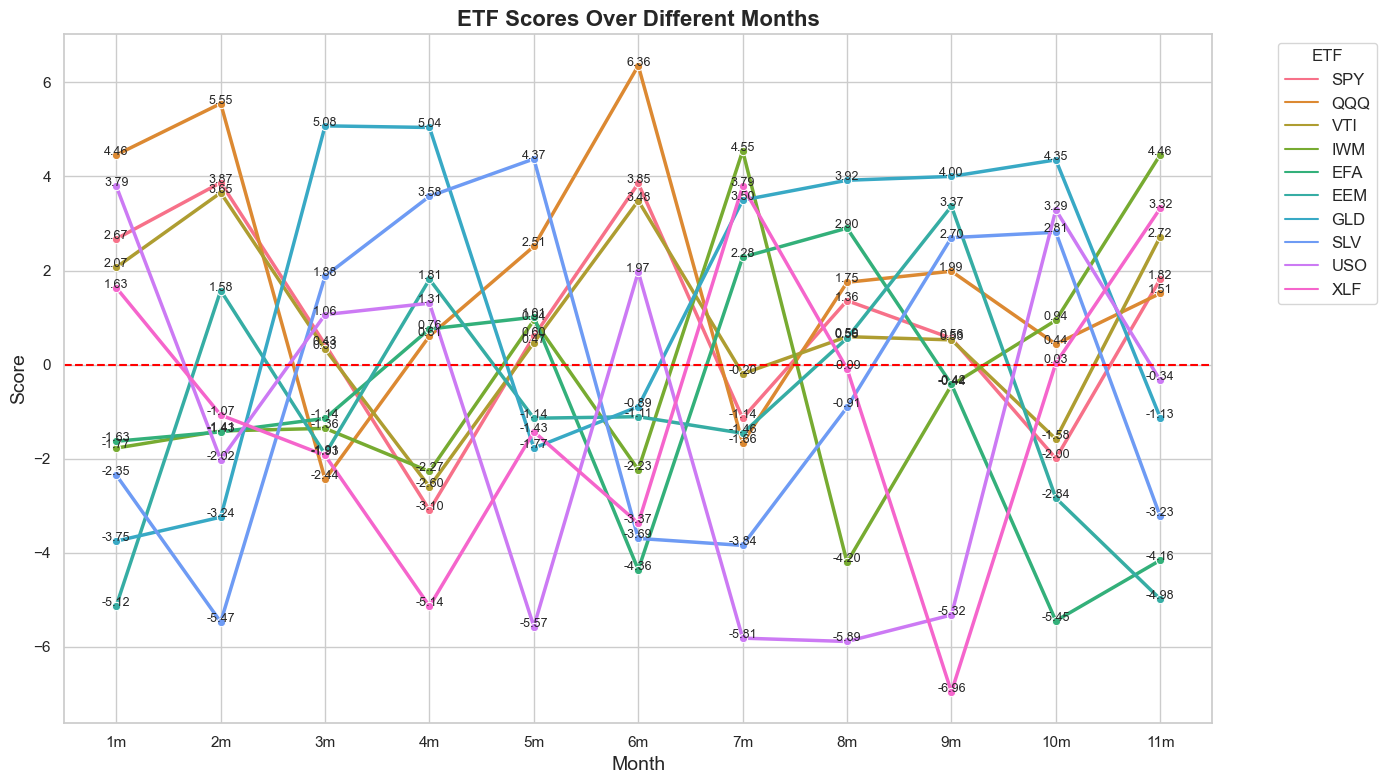

In [55]:
df_scores_all = pd.concat([df_scores_1m, df_scores_2m, df_scores_3m, df_scores_4m, df_scores_5m, df_scores_6m, df_scores_7m, df_scores_8m, df_scores_9m, df_scores_10m, df_scores_11m])
month_order = ['1m', '2m', '3m', '4m', '5m','6m','7m','8m','9m','10m','11m']
df_scores_all['Month'] = pd.Categorical(df_scores_all['Month'], categories=month_order, ordered=True)

plot_scores_line(df_scores_all)


In [56]:
def select_top_etfs(df_scores, forecast_period):
    top_etfs = df_scores.nlargest(2, 'Score')
    print(f"Top 2 ETFs for {forecast_period}-month forecast:")
    print(top_etfs)
    return top_etfs['ETF'].tolist()

def gather_etf_data_for_months(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = pd.to_datetime(start_date).strftime('%Y-%m')
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
            #print(f"Data for {ticker} in {month} gathered.")
    return etf_histories


In [57]:
# Initialize ticker_shares dictionary at the start of the process
ticker_shares = {}

def initialize_shares_for_first_month(top_etfs_1m, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = f'{month}-01'
    
    # Loop through each ETF in the top 2
    for ticker in top_etfs_1m:
        etf_history = etf_histories.get(ticker)
        
        if etf_history is not None:
            # Get the first business day of the month
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            
            # Extract the closing price on the first trading day
            price_on_first_trading_day = etf_history.loc[first_trading_day, 'Close']
            
            # Calculate the number of shares with the provided investment amount
            num_shares = (investment_amount * 0.975)/ price_on_first_trading_day
            print("Shares 1st month: (",investment_amount, " * 0.975)/ (", price_on_first_trading_day ,")")
            # Store the number of shares in the dictionary
            ticker_shares[ticker] = num_shares
            
            # Print the result for each top ETF
            print(f"Ticker: {ticker}, First trading day: {first_trading_day.date()}, Price: {price_on_first_trading_day}, Shares: {num_shares:.2f}")
        else:
            print(f"No data found for {ticker} in {month}")

    # Return the ticker shares dictionary for this month
    return ticker_shares



In [58]:
# Updated portfolio management function to fix the month format issue
def manage_etf_portfolio(top_etfs_previous, top_etfs_current, previous_month, current_month, ticker_shares, gathered_data_per_month):
    # Use the current month directly as it's already a string like '2024-02'
    etf_histories_for_current_month = gathered_data_per_month.get(current_month, {})

    # Extract ETFs as lists to preserve order
    top2etfs_previous = list(top_etfs_previous)
    top2etfs_current = list(top_etfs_current)

    print(f"Top 2 ETFs for {previous_month}: {top2etfs_previous}")
    print(f"Top 2 ETFs for {current_month}: {top2etfs_current}")

    # Step 1: Identify common ETFs (present in both months)
    etfs_common = [etf for etf in top2etfs_previous if etf in top2etfs_current]

    # Step 2: Identify ETFs to sell (present in the previous month but not in the current month)
    etfs_to_sell = [etf for etf in top2etfs_previous if etf not in top2etfs_current]

    # Step 3: Identify ETFs to buy (present in the current month but not in the previous month)
    etfs_to_buy = [etf for etf in top2etfs_current if etf not in top2etfs_previous]

    # Step 4: Sell ETFs that are no longer in the current top ETFs
    total_selling_value = 0
    for etf in etfs_to_sell:
        no_of_shares = ticker_shares.get(etf, 0)
        if no_of_shares > 0:
            # Check if data for the ETF is available in the current month
            if etf in etf_histories_for_current_month:
                first_trading_day_current_month = etf_histories_for_current_month[etf].loc[etf_histories_for_current_month[etf].index[0], 'Close']
                
                selling_value = no_of_shares * first_trading_day_current_month * 0.975
                print("Formula: ",no_of_shares," * ", first_trading_day_current_month,"* 0.975")
                total_selling_value += selling_value  # Sum total selling value
                print(f"Sell {etf}: {no_of_shares:.2f} shares at {first_trading_day_current_month:.2f}. Total value: {selling_value:.2f}  \n")
                del ticker_shares[etf]
            else:
                print(f"Data for {etf} is missing for {current_month}. Skipping sale.")
        else:
            print(f"No shares found for {etf} to sell.")

    # Step 5: Buy new ETFs that were not in the previous month's top ETFs
    for etf in etfs_to_buy:
        if total_selling_value > 0 and etf in etf_histories_for_current_month:
            first_trading_day_new_etf = etf_histories_for_current_month[etf].loc[etf_histories_for_current_month[etf].index[0], 'Close']
            new_shares = (total_selling_value * 0.975) / first_trading_day_new_etf
            print("Formula: ()",total_selling_value," * 0.975)/", first_trading_day_current_month)
            
            print(f"Buy {etf}: {new_shares:.2f} shares at {first_trading_day_new_etf:.2f}. \n")
            ticker_shares[etf] = new_shares
        else:
            print(f"Data for {etf} is missing or no selling value available. Skipping purchase of {etf}.")

    # Step 6: Maintain the order of ETFs in the ticker_shares dictionary based on the current top 2 ETFs
    ordered_ticker_shares = {etf: ticker_shares[etf] for etf in top2etfs_current if etf in ticker_shares}

    print(f"Updated ticker shares after {current_month}: {ordered_ticker_shares}")
    print("")
    return ordered_ticker_shares



### Value at the end of 7th Month

### WIth Smoothing

In [59]:
# Helper function to apply Exponential Moving Average (EMA) smoothing
def smooth_scores(scores, alpha=0.2):
    """
    Smooth scores using Exponential Moving Average (EMA).
    
    Parameters:
    - scores (list or np.ndarray): List or array of numerical values to be smoothed.
    - alpha (float): Smoothing factor, between 0 and 1. Higher alpha discounts older observations faster.
    
    Returns:
    - smoothed_scores (list): EMA-smoothed scores.
    """
    if not isinstance(scores, (list, np.ndarray)):
        raise ValueError("Scores must be a list or numpy array of numerical values.")
    
    scores = np.array(scores)
    smoothed_scores = np.zeros_like(scores)
    
    # Initialize the first value of the EMA
    smoothed_scores[0] = scores[0]
    
    # Calculate the EMA for the remaining scores
    for t in range(1, len(scores)):
        smoothed_scores[t] = alpha * scores[t] + (1 - alpha) * smoothed_scores[t - 1]
    
    return smoothed_scores.tolist()


# Helper function to apply simple moving average smoothing
'''def smooth_scores(scores, window_size=5):
    if isinstance(scores, list) or isinstance(scores, np.ndarray):
        smoothed_scores = np.convolve(scores, np.ones(window_size) / window_size, mode='valid')
        # Replace padding logic with raw scores for remaining length
        smoothed_scores = list(scores[:len(scores) - len(smoothed_scores)]) + list(smoothed_scores)
        return smoothed_scores
    else:
        raise ValueError("Scores must be a list or numpy array of numerical values.")
'''    

def main(tickers, etf_dict):
    etf_pred_dict = process_etf_data(tickers, etf_dict)
    
    risk_percentage = 0.10

    # Calculate scores for each forecast period (1m, 2m, etc.)
    scores_1m = calculate_scores_for_etfs(etf_pred_dict, '1m', risk_percentage)
    scores_2m = calculate_scores_for_etfs(etf_pred_dict, '2m', risk_percentage)
    scores_3m = calculate_scores_for_etfs(etf_pred_dict, '3m', risk_percentage)
    scores_4m = calculate_scores_for_etfs(etf_pred_dict, '4m', risk_percentage)
    scores_5m = calculate_scores_for_etfs(etf_pred_dict, '5m', risk_percentage)
    scores_6m = calculate_scores_for_etfs(etf_pred_dict, '6m', risk_percentage)
    scores_7m = calculate_scores_for_etfs(etf_pred_dict, '7m', risk_percentage)
    scores_8m = calculate_scores_for_etfs(etf_pred_dict, '8m', risk_percentage)
    scores_9m = calculate_scores_for_etfs(etf_pred_dict, '9m', risk_percentage)
    scores_10m = calculate_scores_for_etfs(etf_pred_dict, '10m', risk_percentage)
    scores_11m = calculate_scores_for_etfs(etf_pred_dict, '11m', risk_percentage)
    
    

    # Collect all scores for each ETF across different periods
    etf_scores_dict = {}
    forecast_periods = ['1m', '2m', '3m', '4m', '5m', '6m', '7m','8m','9m','10m','11m']
    all_scores = [scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m, scores_8m, scores_9m, scores_10m, scores_11m]

    for scores_list in all_scores:
        for score_dict in scores_list:
            etf = score_dict['ETF']
            if etf not in etf_scores_dict:
                etf_scores_dict[etf] = []
            etf_scores_dict[etf].append(score_dict['Score'])

    # Now apply smoothing to each ETF's scores
    smoothed_scores_dict = {}
    for etf, scores in etf_scores_dict.items():
        #smoothed_scores = smooth_scores(scores, window_size=3)  # Apply smoothing with a window size of 3
        smoothed_scores = smooth_scores(scores) 
        smoothed_scores_dict[etf] = smoothed_scores

    # Print the smoothed scores
    for etf, smoothed_scores in smoothed_scores_dict.items():
        print(f"Smoothed scores for {etf}: {smoothed_scores}")

    #return etf_pred_dict, smoothed_scores_dict, scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m

    #for scores in [scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m, scores_8m, scores_9m, scores_10m, scores_11m]:
    #    for score in scores:
    #        print(score)

    return etf_pred_dict, smoothed_scores_dict, scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m,  scores_8m, scores_9m, scores_10m, scores_11m



In [60]:
etf_pred_dict, smoothed_scores_dict, scores_1m, scores_2m, scores_3m, scores_4m, scores_5m, scores_6m, scores_7m,  scores_8m, scores_9m, scores_10m, scores_11m = main(tickers, etf_dict)

Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Fetching Sortino ratios
Smoothed scores for SPY: [2.673849532223113, 2.9130463759136656, 2.415835683877925, 1.3136097259050135, 1.171111274644304, 1.707262492616114, 1.1381637443346004, 1.1825457930863315, 1.0578537333140372, 0.4471649122919399, 0.7209867647148474]
Smoothed scores for QQQ: [4.459543991687989, 4.67769224658491, 3.2539712356600496, 2.724701682000296, 2.6824278175557237, 3.417068206114023, 2.400843623698908, 2.2706131606765676, 2.2135391997620926, 1.8579198703538538, 1.7890815325076346]
Smoothed scores for VTI: [2.069380926373182, 2.3863857676988456, 1.9746831448547184, 1.0600825624497063, 0.9418864173421022, 1.450396120759049, 1.1212238022791023, 1.0157790078352351, 0.9177722496686048, 0.41783936792784565, 0.8780493474623122]
Smoothed 

In [61]:
import pandas as pd

# Create DataFrames from the original scores
df_scores_1m = pd.DataFrame(scores_1m)
df_scores_2m = pd.DataFrame(scores_2m)
df_scores_3m = pd.DataFrame(scores_3m)
df_scores_4m = pd.DataFrame(scores_4m)
df_scores_5m = pd.DataFrame(scores_5m)
df_scores_6m = pd.DataFrame(scores_6m)
df_scores_7m = pd.DataFrame(scores_7m)

df_scores_8m = pd.DataFrame(scores_8m)
df_scores_9m = pd.DataFrame(scores_9m)
df_scores_10m = pd.DataFrame(scores_10m)
df_scores_11m = pd.DataFrame(scores_11m)

# Helper function to update the DataFrame with smoothed scores
def update_dataframe_with_smoothed_scores(df, smoothed_scores_dict, forecast_period):
    # Loop through each row in the DataFrame and update the 'Score' column
    for index, row in df.iterrows():
        etf = row['ETF']
        if etf in smoothed_scores_dict:
            smoothed_score = smoothed_scores_dict[etf][forecast_period]
            df.at[index, 'Score'] = smoothed_score
    return df

# Update each DataFrame with the smoothed scores
df_scores_1m = update_dataframe_with_smoothed_scores(df_scores_1m, smoothed_scores_dict, 0)  # 0 corresponds to 1m
df_scores_2m = update_dataframe_with_smoothed_scores(df_scores_2m, smoothed_scores_dict, 1)  # 1 corresponds to 2m
df_scores_3m = update_dataframe_with_smoothed_scores(df_scores_3m, smoothed_scores_dict, 2)  # 2 corresponds to 3m
df_scores_4m = update_dataframe_with_smoothed_scores(df_scores_4m, smoothed_scores_dict, 3)  # 3 corresponds to 4m
df_scores_5m = update_dataframe_with_smoothed_scores(df_scores_5m, smoothed_scores_dict, 4)  # 4 corresponds to 5m
df_scores_6m = update_dataframe_with_smoothed_scores(df_scores_6m, smoothed_scores_dict, 5)  # 5 corresponds to 6m
df_scores_7m = update_dataframe_with_smoothed_scores(df_scores_7m, smoothed_scores_dict, 6)  # 6 corresponds to 7m

df_scores_8m = update_dataframe_with_smoothed_scores(df_scores_8m, smoothed_scores_dict, 7)  # 7 corresponds to 8m
df_scores_9m = update_dataframe_with_smoothed_scores(df_scores_9m, smoothed_scores_dict, 8)  # 8 corresponds to 9m
df_scores_10m = update_dataframe_with_smoothed_scores(df_scores_10m, smoothed_scores_dict, 9)  # 9 corresponds to 10m
df_scores_11m = update_dataframe_with_smoothed_scores(df_scores_11m, smoothed_scores_dict, 10)  # 10 corresponds to 11m


In [62]:
# Select the top 2 ETFs based on scores for 1-month forecast
top_etfs_1m = df_scores_1m.nlargest(2, 'Score')
print("Top 2 ETFs for 1-month forecast:")
print(top_etfs_1m)

# Select the top 2 ETFs based on scores for 2-month forecast
top_etfs_2m = df_scores_2m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 2-month forecast:")
print(top_etfs_2m)

# Select the top 2 ETFs based on scores for 3-month forecast
top_etfs_3m = df_scores_3m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 3-month forecast:")
print(top_etfs_3m)

# Select the top 2 ETFs based on scores for 4-month forecast
top_etfs_4m = df_scores_4m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 4-month forecast:")
print(top_etfs_4m)

# Select the top 2 ETFs based on scores for 5-month forecast
top_etfs_5m = df_scores_5m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 5-month forecast:")
print(top_etfs_5m)

# Select the top 2 ETFs based on scores for 4-month forecast
top_etfs_6m = df_scores_6m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 6-month forecast:")
print(top_etfs_6m)

# Select the top 2 ETFs based on scores for 5-month forecast
top_etfs_7m = df_scores_7m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 7-month forecast:")
print(top_etfs_7m)

# Select the top 2 ETFs based on scores for 8-month forecast
top_etfs_8m = df_scores_8m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 8-month forecast:")
print(top_etfs_8m)

# Select the top 2 ETFs based on scores for 9-month forecast
top_etfs_9m = df_scores_9m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 9-month forecast:")
print(top_etfs_9m)

# Select the top 2 ETFs based on scores for 10-month forecast
top_etfs_10m = df_scores_10m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 10-month forecast:")
print(top_etfs_10m)

# Select the top 2 ETFs based on scores for 11-month forecast
top_etfs_11m = df_scores_11m.nlargest(2, 'Score')
print("\nTop 2 ETFs for 11-month forecast:")
print(top_etfs_11m)

Top 2 ETFs for 1-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    1m             0.1  4.459544
8  USO    1m             0.1  3.791886

Top 2 ETFs for 2-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    2m             0.1  4.677692
0  SPY    2m             0.1  2.913046

Top 2 ETFs for 3-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    3m             0.1  3.253971
0  SPY    3m             0.1  2.415836

Top 2 ETFs for 4-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    4m             0.1  2.724702
8  USO    4m             0.1  2.113872

Top 2 ETFs for 5-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    5m             0.1  2.682428
0  SPY    5m             0.1  1.171111

Top 2 ETFs for 6-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    6m             0.1  3.417068
0  SPY    6m             0.1  1.707262

Top 2 ETFs for 7-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    7m          

In [63]:
# Define month ranges for data gathering
month_ranges = [
    ('2024-01-01', '2024-01-31'),
    ('2024-02-01', '2024-02-29'),
    ('2024-03-01', '2024-03-31'),
    ('2024-04-01', '2024-04-30'),
    ('2024-05-01', '2024-05-31'),
    ('2024-06-01', '2024-06-30'),
    ('2024-07-01', '2024-07-31'),
    ('2024-08-01', '2024-08-31'),
    ('2024-09-01', '2024-09-30'),
    ('2024-10-01', '2024-10-31'),
    ('2024-11-01', '2024-11-30')
]

# Step 1: Select Top ETFs for each forecast period
top_etfs_1m = select_top_etfs(df_scores_1m, 1)
top_etfs_2m = select_top_etfs(df_scores_2m, 2)
top_etfs_3m = select_top_etfs(df_scores_3m, 3)
top_etfs_4m = select_top_etfs(df_scores_4m, 4)
top_etfs_5m = select_top_etfs(df_scores_5m, 5)
top_etfs_6m = select_top_etfs(df_scores_6m, 6)
top_etfs_7m = select_top_etfs(df_scores_7m, 7)

top_etfs_8m = select_top_etfs(df_scores_8m, 8)
top_etfs_9m = select_top_etfs(df_scores_9m, 9)
top_etfs_10m = select_top_etfs(df_scores_10m, 10)
top_etfs_11m = select_top_etfs(df_scores_11m, 11)

# Step 2: Gather historical data for all months
#tickers = list(set(top_etfs_1m + top_etfs_2m + top_etfs_3m + top_etfs_4m))
tickers = list(set(top_etfs_1m + top_etfs_2m + top_etfs_3m + top_etfs_4m + top_etfs_5m + top_etfs_6m + top_etfs_7m + top_etfs_8m + top_etfs_9m + top_etfs_10m + top_etfs_11m))

etf_histories = gather_etf_data_for_months(tickers, month_ranges)

# Verify gathered data
#for month, data in etf_histories.items():
#    print(f"Data for {month}: {data.keys()}")  # Should print tickers for each month

# Step 3: Perform portfolio optimization for each month
# Start with the first month's portfolio
ticker_shares = {}
ticker_shares_per_month = {}

# For January
ticker_shares_1m = initialize_shares_for_first_month(top_etfs_1m, etf_histories['2024-01'], '2024-01', investment_amount=50000)
ticker_shares_per_month['2024-01'] = ticker_shares_1m.copy()

# For February
ticker_shares_2m = manage_etf_portfolio(top_etfs_1m, top_etfs_2m, '2024-01', '2024-02', ticker_shares_1m, etf_histories)
ticker_shares_per_month['2024-02'] = ticker_shares_2m.copy()

# For March
ticker_shares_3m = manage_etf_portfolio(top_etfs_2m, top_etfs_3m, '2024-02', '2024-03', ticker_shares_2m, etf_histories)
ticker_shares_per_month['2024-03'] = ticker_shares_3m.copy()

# For April
ticker_shares_4m = manage_etf_portfolio(top_etfs_3m, top_etfs_4m, '2024-03', '2024-04', ticker_shares_3m, etf_histories)
ticker_shares_per_month['2024-04'] = ticker_shares_4m.copy()

# For May
ticker_shares_5m = manage_etf_portfolio(top_etfs_4m, top_etfs_5m, '2024-04', '2024-05', ticker_shares_4m, etf_histories)
ticker_shares_per_month['2024-05'] = ticker_shares_5m.copy()

# For June
ticker_shares_6m = manage_etf_portfolio(top_etfs_5m, top_etfs_6m, '2024-05', '2024-06', ticker_shares_5m, etf_histories)
ticker_shares_per_month['2024-06'] = ticker_shares_6m.copy()

# For July
ticker_shares_7m = manage_etf_portfolio(top_etfs_6m, top_etfs_7m, '2024-06', '2024-07', ticker_shares_6m, etf_histories)
ticker_shares_per_month['2024-07'] = ticker_shares_7m.copy()

# For August
ticker_shares_8m = manage_etf_portfolio(top_etfs_7m, top_etfs_8m, '2024-07', '2024-08', ticker_shares_7m, etf_histories)
ticker_shares_per_month['2024-08'] = ticker_shares_8m.copy()

# For September
ticker_shares_9m = manage_etf_portfolio(top_etfs_8m, top_etfs_9m, '2024-08', '2024-09', ticker_shares_8m, etf_histories)
ticker_shares_per_month['2024-09'] = ticker_shares_9m.copy()

# For October
ticker_shares_10m = manage_etf_portfolio(top_etfs_9m, top_etfs_10m, '2024-09', '2024-10', ticker_shares_9m, etf_histories)
ticker_shares_per_month['2024-10'] = ticker_shares_10m.copy()

# For November
ticker_shares_11m = manage_etf_portfolio(top_etfs_10m, top_etfs_11m, '2024-10', '2024-11', ticker_shares_10m, etf_histories)
ticker_shares_per_month['2024-11'] = ticker_shares_11m.copy()


# Debug output for each month's portfolio
for month, shares in ticker_shares_per_month.items():
    print(f"Ticker shares after {month}: {shares}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Top 2 ETFs for 1-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    1m             0.1  4.459544
8  USO    1m             0.1  3.791886
Top 2 ETFs for 2-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    2m             0.1  4.677692
0  SPY    2m             0.1  2.913046
Top 2 ETFs for 3-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    3m             0.1  3.253971
0  SPY    3m             0.1  2.415836
Top 2 ETFs for 4-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    4m             0.1  2.724702
8  USO    4m             0.1  2.113872
Top 2 ETFs for 5-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    5m             0.1  2.682428
0  SPY    5m             0.1  1.171111
Top 2 ETFs for 6-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    6m             0.1  3.417068
0  SPY    6m             0.1  1.707262
Top 2 ETFs for 7-month forecast:
   ETF Month  RiskPercentage     Score
1  QQQ    7m             0.1


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Shares 1st month: ( 50000  * 0.975)/ ( 402.5899963378906 )
Ticker: QQQ, First trading day: 2024-01-02, Price: 402.5899963378906, Shares: 121.09
Shares 1st month: ( 50000  * 0.975)/ ( 65.7699966430664 )
Ticker: USO, First trading day: 2024-01-02, Price: 65.7699966430664, Shares: 741.22
Top 2 ETFs for 2024-01: ['QQQ', 'USO']
Top 2 ETFs for 2024-02: ['QQQ', 'SPY']
Formula:  741.2194387748888  *  69.06999969482422 * 0.975
Sell USO: 741.22 shares at 69.07. Total value: 49916.13  

Formula: () 49916.125749729865  * 0.975)/ 69.06999969482422
Buy SPY: 99.49 shares at 489.20. 

Updated ticker shares after 2024-02: {'QQQ': 121.09093728967002, 'SPY': 99.48532582086291}

Top 2 ETFs for 2024-02: ['QQQ', 'SPY']
Top 2 ETFs for 2024-03: ['QQQ', 'SPY']
Updated ticker shares after 2024-03: {'QQQ': 121.09093728967002, 'SPY': 99.48532582086291}

Top 2 ETFs for 2024-03: ['QQQ', 'SPY']
Top 2 ETFs for 2024-04: ['QQQ', 'USO']
Formula:  99.48532582086291  *  522.1599731445312 * 0.975
Sell SPY: 99.49 shares at 

In [64]:
# Define the 7th month start date (adjust year/month as needed)
first_trading_day = '2024-11-01'  # Start date for the 7th month
#end_date = '2024-07-31'  # End date buffer to account for non-trading days

# Fetch first trading day prices for each ETF
first_day_prices = {}
for ticker in ticker_shares_11m:
    # Download historical data within a date range
    data = yf.download(ticker, start=first_trading_day)
    # Get the first available closing price in the data
    first_closing_price = data['Close'].iloc[0] if not data.empty else None
    first_day_prices[ticker] = first_closing_price

# Display the first trading day prices
for ticker, price in first_day_prices.items():
    print(f"{ticker}: First trading day price in 11th month: ${price:.2f}" if price else f"{ticker}: No data available.")
    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

QQQ: First trading day price in 11th month: $487.43
GLD: First trading day price in 11th month: $252.47


In [65]:
# Calculate the total portfolio value by multiplying shares by their first trading day prices
portfolio_value_11m = sum(shares * first_day_prices[ticker] for ticker, shares in ticker_shares_11m.items() if ticker in first_day_prices)
portfolio_value_11m

110471.7372526008

Processing frame: 1, month: 1m
Processing frame: 1, month: 1m
Processing frame: 2, month: 2m
Processing frame: 3, month: 3m
Processing frame: 4, month: 4m
Processing frame: 5, month: 5m
Processing frame: 6, month: 6m
Processing frame: 7, month: 7m
Processing frame: 8, month: 8m
Processing frame: 9, month: 9m
Processing frame: 10, month: 10m
Processing frame: 11, month: 11m


Processing frame: 1, month: 1m


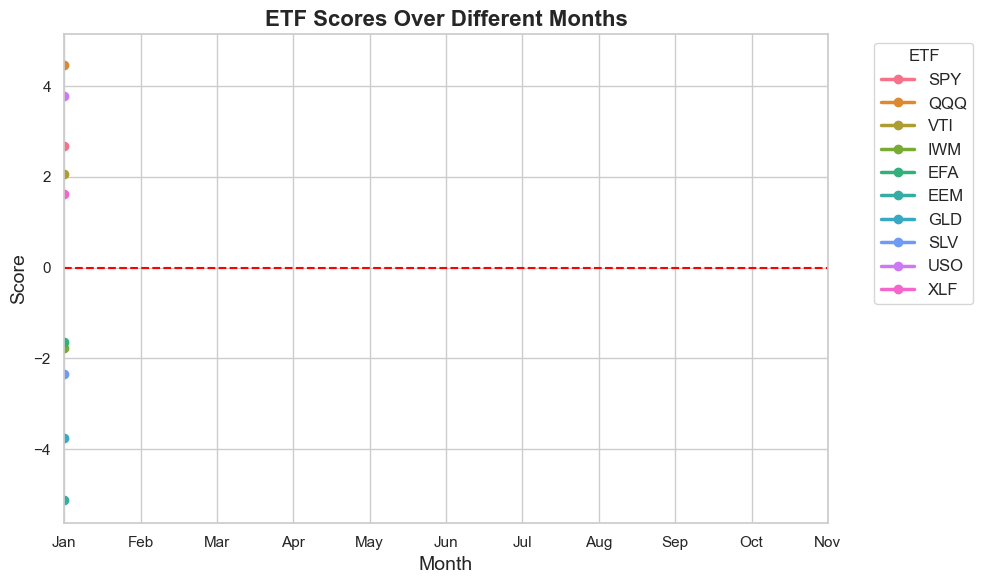

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML

# Enhanced plot function with animation and dynamic y-axis
def animate_scores(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    palette = sns.color_palette("husl", len(df['ETF'].unique()))

    # Prepare an empty lineplot for each ETF
    lines = {etf: ax.plot([], [], marker='o', label=etf, color=color, lw=2.5)[0] 
             for etf, color in zip(df['ETF'].unique(), palette)}
    
    # Set up the plot title, labels, and legend
    ax.set_title('ETF Scores Over Different Months', fontsize=16, weight='bold')
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    ax.axhline(0, color='red', linestyle='--')
    ax.legend(title='ETF', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

    # Dynamically calculate the y-axis limits
    y_min = df['Score'].min() * 1.1
    y_max = df['Score'].max() * 1.1

    # Set dynamic y-axis limits
    ax.set_xlim(1, 5)
    ax.set_xticks([1, 2, 3, 4, 5,6,7,8,9,10,11])

    # Set the x-axis tick labels to three-letter month abbreviations
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul', 'Aug', 'Sep','Oct','Nov']  # Customize this list based on your data
    ax.set_xticklabels(month_labels)

    ax.set_ylim(y_min, y_max)  # Dynamically set y-limits based on the data

    # Function to update the plot frame by frame
    def update(frame):
        if 1 <= frame + 1 <= 11:
            current_month = month_order[frame]
            print(f"Processing frame: {frame+1}, month: {current_month}")
            subset = df[df['Month'] == current_month]
            
            for etf in subset['ETF'].unique():
                etf_data = subset[subset['ETF'] == etf]
                # Update x and y data for each ETF
                x_data = [month_order.index(month) + 1 for month in df[df['ETF'] == etf]['Month'][:frame+1]]
                y_data = df[df['ETF'] == etf]['Score'][:frame+1]
                lines[etf].set_data(x_data, y_data)

            return list(lines.values())
        else:
            print(f"Frame {frame+1} exceeds the available months.")
            return []

    ani = animation.FuncAnimation(fig, update, frames=len(month_order), interval=1000, blit=False)

    plt.tight_layout()  # Make sure all elements fit without overlapping
    
    return ani

# Prepare the data and order the months
df_scores_all = pd.concat([df_scores_1m, df_scores_2m, df_scores_3m, df_scores_4m, df_scores_5m, df_scores_6m, df_scores_7m, df_scores_8m, df_scores_9m, df_scores_10m, df_scores_11m])
month_order = ['1m', '2m', '3m', '4m', '5m','6m','7m','8m','9m','10m','11m']
df_scores_all['Month'] = pd.Categorical(df_scores_all['Month'], categories=month_order, ordered=True)

# Call the animate function
anim = animate_scores(df_scores_all)

# Display the animation in the notebook
HTML(anim.to_jshtml())
